In [1]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.lab_report import DAOLabReport

from dao.attribute import DAOAttributePL

from models.attribute import AttributePL, AttributePLInDB

from ml.model_training import evaluate_models, k_fold_cross_validation
from ml.data_preparation import convert_db_attributes_to_input_data
from typing import List
from analysis.nlp_transformations import replace_links_with_text
from ml.data_preparation import find_significant_features

[nltk_data] Downloading package stopwords to /home/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pawel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package pl196x to /home/pawel/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/pawel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
dao_lab_reports: DAOLabReport = DAOLabReport('lab_reports-24-12-16')

dao_attribute: DAOAttributePL = DAOAttributePL('attributes-24-12-16')


generated: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": True})
real: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": False})

generated_flat_dict = [(x.to_flat_dict_normalized(), 1) for x in generated]
real_flat_dict = [(x.to_flat_dict_normalized(), 0) for x in real]

In [16]:
dao_attributes_to_compare: DAOAttributePL = DAOAttributePL('attributes_manual_test3')
generated_to_compare: List[AttributePLInDB] = dao_attributes_to_compare.find_many_by_query({"is_generated": True})
real_to_compare: List[AttributePLInDB] = dao_attributes_to_compare.find_many_by_query({"is_generated": False})

generated_flat_dict_to_compare = [(x.to_flat_dict_normalized(), 1) for x in generated_to_compare]
real_flat_dict_to_compare = [(x.to_flat_dict_normalized(), 0) for x in real_to_compare]

In [21]:
dao_attributes_to_compare2: DAOAttributePL = DAOAttributePL('attributes_manual_test4')
generated_to_compare2: List[AttributePLInDB] = dao_attributes_to_compare2.find_many_by_query({"is_generated": True})
real_to_compare2: List[AttributePLInDB] = dao_attributes_to_compare2.find_many_by_query({"is_generated": False})

generated_flat_dict_to_compare2 = [(x.to_flat_dict_normalized(), 1) for x in generated_to_compare2]
real_flat_dict_to_compare2 = [(x.to_flat_dict_normalized(), 0) for x in real_to_compare2]

In [3]:
data = [(x.to_flat_dict_normalized(), 1) for x in generated]
data += [(x.to_flat_dict_normalized(), 0) for x in real]
# replace None with 0
for i in range(len(data)):
    for key in data[i][0].keys():
        if data[i][0][key] is None:
            data[i][0][key] = 0

significant_features = find_significant_features(data)

In [4]:
significant_features

['stylometrix_metrics.syntactic.SY_S_NOM',
 'number_of_errors',
 'text_errors_by_category.TYPOGRAPHY',
 'average_sentence_char_length',
 'average_sentence_word_length',
 'average_word_char_length',
 'punctuation_per_sentence',
 'standard_deviation_sentence_word_length',
 'variance_sentence_word_length',
 'stylometrix_metrics.grammatical_forms.G_PRO_REL',
 'punctuation_density',
 'standard_deviation_sentence_char_length',
 'variance_sentence_char_length',
 'stylometrix_metrics.grammatical_forms.G_NUM',
 'stylometrix_metrics.inflection.IN_V_1P',
 'stylometrix_metrics.inflection.IN_PRO_1NOM',
 'no_space_after_punctuation',
 'text_errors_by_category.PUNCTUATION',
 'stylometrix_metrics.inflection.IN_V_IMPERS',
 'stylometrix_metrics.inflection.IN_V_IMPERS_PERF',
 'stylometrix_metrics.graphical.GR_UPPER',
 'burstiness2',
 'stylometrix_metrics.inflection.IN_V_3P',
 'stylometrix_metrics.syntactic.SY_FMWE',
 'stylometrix_metrics.punctuation.PUNCT_TOTAL',
 'stylometrix_metrics.inflection.IN_N_1NO

In [19]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 21, max_value=5, min_value=0, metric_name="Metric", top=0.5, file_name=""):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    weights = np.ones_like(data_to_plot) / len(data_to_plot)
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w), weights=weights)
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.ylim(top=top)
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Lab reports share')
    # plt.xticks([i for i in range(min_value, max_value+1, 2)])
    plt.savefig(f'../images/{file_name}.png')
    plt.show()

def plot_two_hists(data1, data2, title, metric_name="Metric", num_bin=21, min_value=0, max_value=5, top=0.5, additional_values=None):
    # Truncate data to max_value if needed
    data1_to_plot = [d if d < max_value else max_value for d in data1]
    data2_to_plot = [d if d < max_value else max_value for d in data2]

    w = (max_value - min_value) / num_bin
    bins = np.arange(min_value, max_value + w, w)
    
    weights1 = np.ones_like(data1_to_plot) / len(data1_to_plot)
    weights2 = np.ones_like(data2_to_plot) / len(data2_to_plot)
    
    plt.hist(data1_to_plot, bins=bins, weights=weights1, alpha=0.7, label='Generated', color='red')
    plt.hist(data2_to_plot, bins=bins, weights=weights2, alpha=0.7, label='Real', color='blue')
    if additional_values is not None:
        if len(additional_values) == 2:
            plt.axvline(additional_values[0], color='red', linestyle='--', linewidth=1, label='Generated sample')
            plt.axvline(additional_values[1], color='blue', linestyle='--', linewidth=1, label='Real sample')
        elif len(additional_values) == 4:
            plt.axvline(additional_values[0], color='red', linestyle='--', linewidth=1, label='Generated sample 1')
            plt.axvline(additional_values[1], color='orange', linestyle='--', linewidth=1, label='Generated sample 2')
            plt.axvline(additional_values[2], color='blue', linestyle='--', linewidth=1, label='Real sample 1')
            plt.axvline(additional_values[3], color='green', linestyle='--', linewidth=1, label='Real sample 2')
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.ylim(top=top)
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Lab reports share')
    plt.legend()
    plt.show()
    
def compare_2_hists(attribute_name: str, min_value=None, max_value=None, top=0.41, num_bin = 21, one_hist=False, additional_values=None):
    data_gen = [attribute[0][attribute_name] for attribute in generated_flat_dict]
    data_real = [attribute[0][attribute_name] for attribute in real_flat_dict]
    if min_value is None:
        min_value = 0# min(min(data_gen), min(data_real))
    if max_value is None:
        max_value = max(np.percentile(data_gen, 99), np.percentile(data_real, 99))
    
    if not one_hist:
        hist_attribute(data_gen, f'Generated lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_gen")
        hist_attribute(data_real, f'Real lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_rel")
    else:
        plot_two_hists(data_gen, data_real, f'Generated vs Real lab reports', metric_name=attribute_name, min_value=min_value, max_value=max_value, top=top, num_bin=num_bin, additional_values=additional_values)

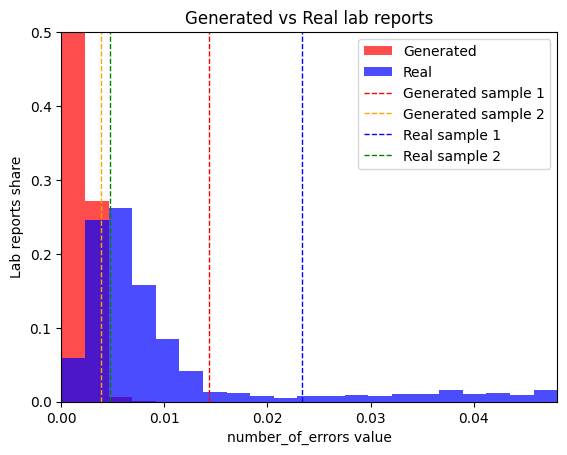

In [22]:
attribute_name = 'number_of_errors'
gen_values = generated_flat_dict_to_compare[0][0][attribute_name]
real_values = real_flat_dict_to_compare[0][0][attribute_name]
gen_values2 = generated_flat_dict_to_compare2[0][0][attribute_name]
real_values2 = real_flat_dict_to_compare2[0][0][attribute_name]
compare_2_hists(attribute_name, top=0.5, one_hist=True, additional_values=[gen_values, gen_values2, real_values, real_values2])

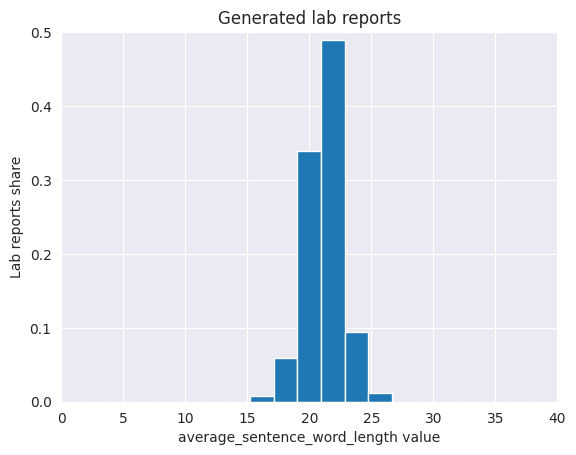

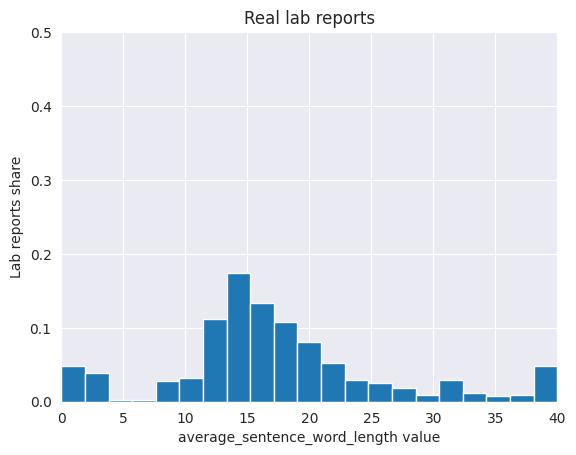

In [22]:
compare_2_hists('average_sentence_word_length', min_value=0, max_value=40, top=0.5)

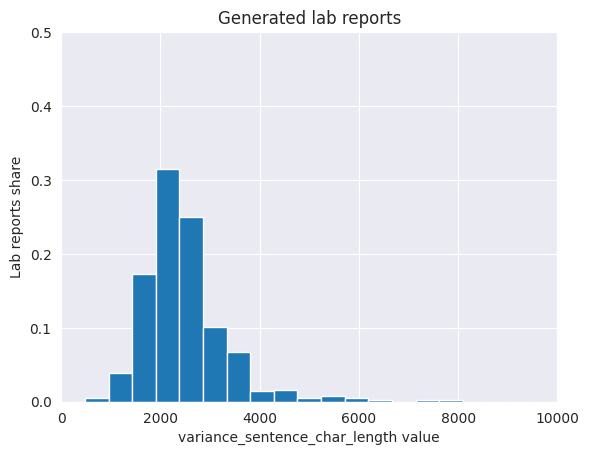

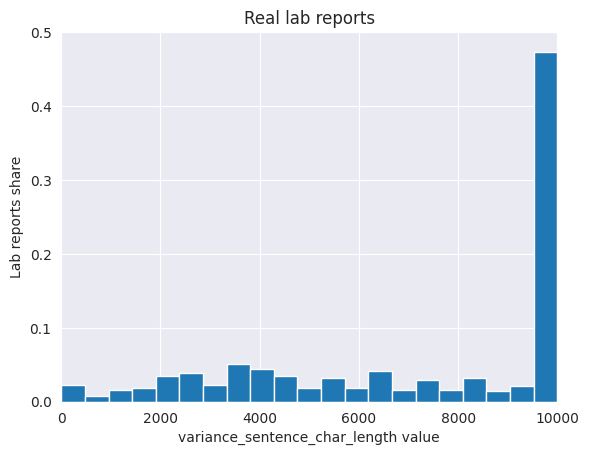

In [28]:
compare_2_hists('variance_sentence_char_length', min_value=0, max_value=10000, top=0.5)

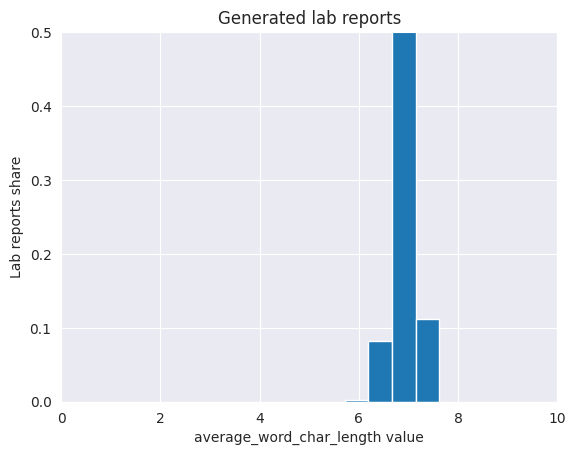

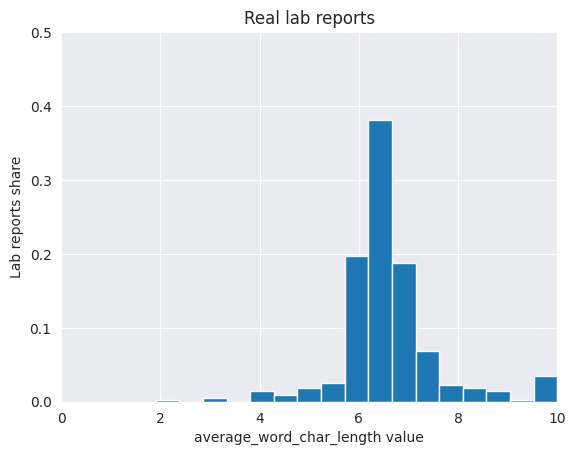

In [31]:
compare_2_hists('average_word_char_length', min_value=0, max_value=10, top=0.5)

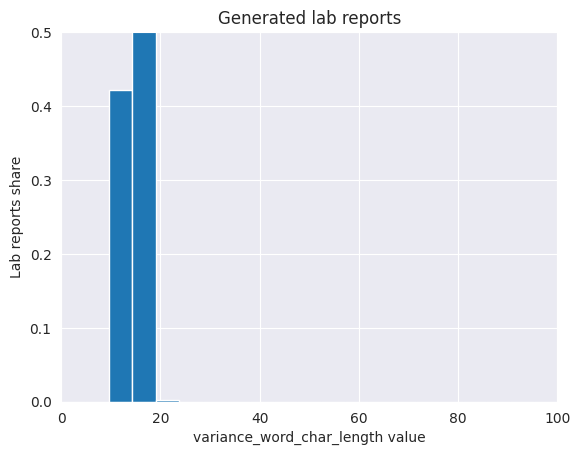

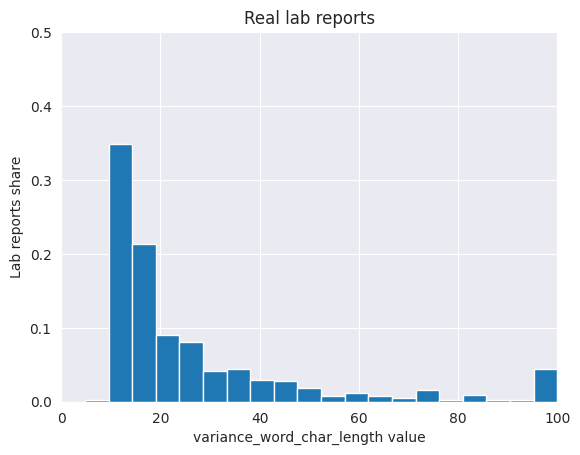

In [35]:
compare_2_hists('variance_word_char_length', min_value=0, max_value=100, top=0.5)

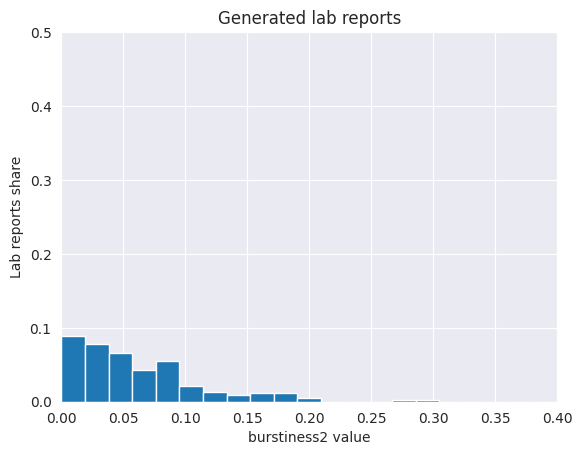

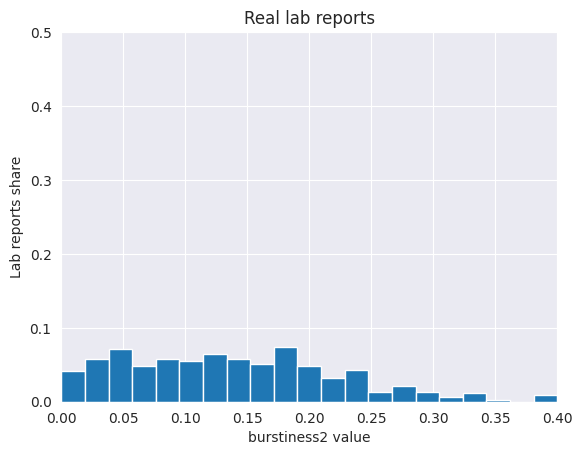

In [38]:
compare_2_hists('burstiness2', min_value=0, max_value=0.4, top=0.5)